In [1]:
import pandas as pd
import numpy as np

In [34]:
df_reg = pd.read_csv('results/regression_linear/processed_quartiles_results_classification_metrics.csv')
df_reg.drop(df_reg[df_reg['dataset'] == 'tic'].index, inplace = True)
df_reg['dataset'] = df_reg['dataset'].replace('lsat', 'lsac')
df_reg.head()

,accuracies,statistical_parity_difference,equal_opportunity_difference,false_discovery_rate_difference,sp_avg_outcome_n,dataset,attribute,method
0,0.711,-0.147,-0.107,-0.048,0.000,singles,sex,binary
1,0.944,0.002,0.000,-0.021,-0.025,insurance,sex,continuous
2,0.795,-0.121,-0.095,0.101,0.000,drugs,Gender,binary
4,0.875,-0.106,-0.439,0.403,0.111,parkinson,sex,binary
5,0.739,-0.364,-0.257,0.112,0.213,compas,race,ordinal


In [3]:
df_reg_bin = df_reg.loc[df_reg['method'] == 'binary']
df_reg_bin = df_reg_bin.drop(columns=['method'])
df_reg_cont = df_reg.loc[df_reg['method'] != 'binary']
df_reg_cont = df_reg_cont.drop(columns=['method'])
df_all = df_reg_bin.merge(df_reg_cont, on=['dataset', 'attribute'])
df_all.head()

,accuracies_x,statistical_parity_difference_x,equal_opportunity_difference_x,false_discovery_rate_difference_x,sp_avg_outcome_n_x,dataset,attribute,accuracies_y,statistical_parity_difference_y,equal_opportunity_difference_y,false_discovery_rate_difference_y,sp_avg_outcome_n_y
0,0.711,-0.147,-0.107,-0.048,0.000,singles,sex,0.711,-0.147,-0.107,-0.048,-0.112
1,0.795,-0.121,-0.095,0.101,0.000,drugs,Gender,0.794,-0.121,-0.095,0.101,0.121
2,0.864,-0.004,-0.020,0.141,-0.000,tic,religion,0.863,-0.002,-0.004,0.116,0.023
3,0.875,-0.106,-0.439,0.403,0.111,parkinson,sex,0.862,-0.016,-0.061,-0.157,0.047
4,0.638,-0.589,-0.538,0.081,-0.364,lsat,race,0.626,-0.572,-0.603,0.081,-0.081


In [4]:
df_all.sort_values(by=['dataset', 'attribute'], inplace=True)
df_regression = df_all[['dataset', 'attribute', 'accuracies_x', 'accuracies_y', 'statistical_parity_difference_x', 'statistical_parity_difference_y', 'equal_opportunity_difference_x', 'equal_opportunity_difference_y', 'false_discovery_rate_difference_x', 'false_discovery_rate_difference_y']]

In [5]:
rename_mapping = {
    'accuracies_x': 'acc_bin',
    'accuracies_y': 'acc_cont',
    'statistical_parity_difference_x': 'spd_bin',
    'statistical_parity_difference_y': 'spd_cont',
    'equal_opportunity_difference_x': 'eod_bin',
    'equal_opportunity_difference_y': 'eod_cont',
    'false_discovery_rate_difference_x': 'fdr_bin',
    'false_discovery_rate_difference_y': 'fdr_cont'
    # ... add more columns you want to rename
}

# Use the `rename` function to rename columns
df_regression = df_regression.rename(columns=rename_mapping)
df_regression

,dataset,attribute,acc_bin,acc_cont,spd_bin,spd_cont,eod_bin,eod_cont,fdr_bin,fdr_cont
8,compas,race,0.739,0.739,-0.364,-0.364,-0.257,-0.257,0.112,0.112
9,crime,race,0.821,0.805,-0.506,-0.450,-0.301,-0.395,0.100,-0.007
1,drugs,Gender,0.795,0.794,-0.121,-0.121,-0.095,-0.095,0.101,0.101
6,insurance,sex,0.978,0.944,0.022,0.002,0.003,0.000,-0.004,-0.021
4,lsat,race,0.638,0.626,-0.589,-0.572,-0.538,-0.603,0.081,0.081
5,obesity,Gender,0.993,0.994,-0.015,-0.014,-0.001,0.000,0.001,0.001
7,older-adults,sex,0.589,0.572,-0.298,-0.500,-0.307,-0.430,0.163,0.061
3,parkinson,sex,0.875,0.862,-0.106,-0.016,-0.439,-0.061,0.403,-0.157
0,singles,sex,0.711,0.711,-0.147,-0.147,-0.107,-0.107,-0.048,-0.048
10,student,sex,0.728,0.729,-0.165,-0.146,-0.094,-0.076,0.063,0.070


This is the way to perform a Wilcoxon signed-rank test in Python:
We maybe should apply it to every metric.

In [6]:
from scipy.stats import wilcoxon
# Perform Wilcoxon signed-rank test
sp_w = df_regression[['spd_bin', 'spd_cont']]
sp = sp_w.loc[sp_w['spd_bin'] != sp_w['spd_cont']]
sp_wilcoxon = wilcoxon(sp['spd_bin'], sp['spd_cont'])
print(sp_wilcoxon)

WilcoxonResult(statistic=15.0, pvalue=0.42578125)


Now I will make the same data preparation for the tree results


In [7]:
df_tree = pd.read_csv('results/regression_tree/processed_quartiles_results_classification_metrics.csv')
df_tree.head()

,accuracies,statistical_parity_difference,equal_opportunity_difference,false_discovery_rate_difference,sp_avg_outcome_n,dataset,attribute,method
0,0.753,-0.110,-0.055,0.084,-0.022,wine,color,binary
1,1.000,-0.221,0.000,0.000,0.186,older-adults,sex,continuous
2,0.791,-0.304,-0.171,0.118,0.183,compas,race,ordinal
3,0.660,-0.095,-0.053,0.116,-0.005,student,sex,binary
4,1.000,-0.131,0.000,0.000,-0.048,wine,color,ordinal


In [8]:
df_tree_bin = df_tree.loc[df_tree['method'] == 'binary']
df_tree_bin = df_tree_bin.drop(columns=['method'])
df_tree_cont = df_tree.loc[df_tree['method'] != 'binary']
df_tree_cont = df_tree_cont.drop(columns=['method'])
df_all_tree = df_tree_bin.merge(df_tree_cont, on=['dataset', 'attribute'])
df_all_tree.sort_values(by=['dataset', 'attribute'], inplace=True)
df_tree_results = df_all_tree[['dataset', 'attribute', 'accuracies_x', 'accuracies_y', 'statistical_parity_difference_x', 'statistical_parity_difference_y', 'equal_opportunity_difference_x', 'equal_opportunity_difference_y', 'false_discovery_rate_difference_x', 'false_discovery_rate_difference_y']]
# Use the `rename` function to rename columns
df_tree_results = df_tree_results.rename(columns=rename_mapping)
df_tree_results


,dataset,attribute,acc_bin,acc_cont,spd_bin,spd_cont,eod_bin,eod_cont,fdr_bin,fdr_cont
2,compas,race,0.720,0.791,-0.310,-0.304,-0.196,-0.171,0.141,0.118
8,crime,race,0.740,1.000,-0.454,-0.455,-0.286,0.000,0.278,0.000
10,drugs,Gender,0.718,1.000,-0.094,-0.123,-0.072,0.000,0.103,0.000
6,insurance,sex,0.982,1.000,0.023,0.023,0.006,0.000,-0.005,0.000
4,lsat,race,0.560,0.958,-0.183,-0.215,-0.182,0.020,0.209,-0.030
7,obesity,Gender,0.989,1.000,-0.011,-0.015,0.000,0.000,0.007,0.000
5,older-adults,sex,0.467,1.000,-0.330,-0.221,-0.375,0.000,0.264,0.000
9,parkinson,sex,0.917,1.000,-0.087,-0.078,-0.224,0.000,0.188,0.000
11,singles,sex,0.684,0.981,-0.085,-0.103,-0.064,-0.004,0.085,-0.005
1,student,sex,0.660,1.000,-0.095,-0.139,-0.053,0.000,0.116,0.000


Are the values different between two methods? -- no in SP

In [9]:
# Perform Wilcoxon signed-rank test
sp_w = pd.DataFrame([df_regression['spd_bin'], df_regression['spd_bin']], columns=['spd_bin_reg', 'spd_cont_reg'])
sp = sp_w.loc[sp_w['spd_bin_reg'] != sp_w['spd_cont_reg']]
sp_wilcoxon = wilcoxon(sp['spd_bin_reg'], sp['spd_cont_reg'])
print(sp_wilcoxon)

WilcoxonResult(statistic=nan, pvalue=nan)


In [10]:
# Perform Wilcoxon signed-rank test
sp_w = pd.DataFrame([df_regression['spd_cont'], df_tree_results['spd_cont']], columns=['spd_cont_reg', 'spd_cont_tree'])
sp_ = sp_w.loc[sp_w['spd_cont_reg'] != sp_w['spd_cont_tree']]
sp_wilcoxon = wilcoxon(sp_['spd_cont_reg'], sp_['spd_cont_tree'])
print(sp_wilcoxon)

WilcoxonResult(statistic=nan, pvalue=nan)


In [35]:
df_tree.drop(df_tree[df_tree['dataset'] == 'tic'].index, inplace = True)
df_tree['dataset'] = df_tree['dataset'].replace('lsat', 'lsac')
df_tree

,accuracies,statistical_parity_difference,equal_opportunity_difference,false_discovery_rate_difference,sp_avg_outcome_n,dataset,attribute,method
2,0.791,-0.304,-0.171,0.118,0.183,compas,race,ordinal
6,0.720,-0.310,-0.196,0.141,0.034,compas,race,binary
10,1.000,-0.455,0.000,0.000,0.307,crime,race,continuous
16,0.740,-0.454,-0.286,0.278,0.454,crime,race,binary
20,0.718,-0.094,-0.072,0.103,0.016,drugs,Gender,binary
22,1.000,-0.123,0.000,0.000,0.077,drugs,Gender,ordinal
9,1.000,0.023,0.000,0.000,-0.019,insurance,sex,continuous
13,0.982,0.023,0.006,-0.005,-0.000,insurance,sex,binary
8,0.560,-0.183,-0.182,0.209,-0.076,lsac,race,binary
21,0.958,-0.215,0.020,-0.030,-0.082,lsac,race,continuous


Plotting the results

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle


# Set the aesthetic style of the plots
sns.set_style("whitegrid")
# List of metrics to plot
metrics = ['statistical_parity_difference']

# Define the ideal values and fair intervals for the metrics
ideal_values = {
    'statistical_parity_difference': 0,
    'equal_opportunity_difference': 0,
    'false_discovery_rate_difference': 0,
    'accuracies': 0.5  # This is arbitrary as the ideal accuracy depends on the context
}

fair_intervals = {
    'statistical_parity_difference': (-0.1, 0.1),
    'equal_opportunity_difference': (-0.1, 0.1),
    'false_discovery_rate_difference': (-0.1, 0.1),
    'SP': (-0.1, 0.1)
}


# Adjusting the plotting function to correctly annotate the bars and avoid the error

def create_comparison_plots_adjusted(df, metrics, ideal_values, fair_intervals):
    for metric in metrics:
        # Prepare data for plotting
        df.sort_values(by=['dataset', 'attribute'], inplace=True)

        binary_data = df[df['method'] == 'binary'][['dataset', 'attribute', metric]]
        other_data = df[df['method'] != 'binary'][['dataset', 'attribute', metric, 'method']]

        binary_data = binary_data.rename(columns={metric: f'SP'})
        other_data = other_data.rename(columns={metric: f'SP'})
        metric = 'SP'

        # Merge binary and other data for comparison
        merged_data = pd.merge(binary_data, other_data, on=['dataset', 'attribute'], suffixes=('_binary', '_continuous'))

        # Melt the data for seaborn barplot
        melted_data = pd.melt(merged_data, id_vars=['dataset', 'attribute', 'method'],
                              value_vars=[f'{metric}_binary', f'{metric}_continuous'],
                              var_name='Method', value_name=metric)

        # Start plotting
        plt.figure(figsize=(8, 6))

        # If a fair interval is specified, add a patch for it, and label it
        if metric in fair_intervals:
            plt.axhspan(fair_intervals[metric][0], fair_intervals[metric][1], color='#d3d3d3', alpha=0.5, label='Fair',
                        zorder=0)

        barplot = sns.barplot(data=melted_data, x='dataset', y=metric, hue='Method', palette=['#494949', '#cfcfcf'],
                              zorder=3)
        plt.xticks(rotation=45)
        plt.title(f'Comparison of SP: Binary vs Continuous output', fontsize=16)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel('')
        plt.ylabel('')

        # Add a horizontal line for the ideal value
        # plt.axhline(y=ideal_values[metric], color='black', linestyle='--', zorder=2)

        # Add the values on the bars
        for p in barplot.patches:
            # Check if the patch is a Rectangle object (which represents a bar)
            if isinstance(p, Rectangle):
                height = p.get_height()
                # Determine the vertical alignment and set the offset
                va = 'bottom' if height >= 0 else 'top'
                offset = 0.001 if height >= 0 else -0.01
                barplot.annotate(format(height, '.2f'),
                                 (p.get_x() + p.get_width() / 2., height + offset),
                                 ha='center', va=va,
                                 xytext=(0, 9),
                                 textcoords='offset points',
                                 rotation=90)


        # Place the legend
        # plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper center')
        plt.legend(title='Measure', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(df['method'].unique()), fontsize=14)

        # Set the y-axis range
        plt.ylim(-0.65, 0.15)

        # Show the plot
        plt.tight_layout()
        plt.savefig(f'plots/{metric}_tree_comparison.pdf',  bbox_inches='tight')

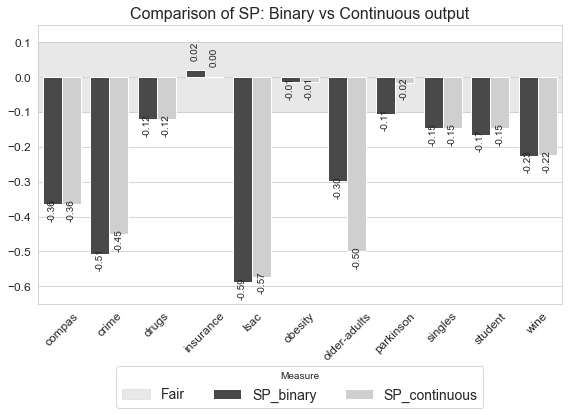

In [36]:
# Create the adjusted plots with intervals behind the bars
create_comparison_plots_adjusted(df_reg, metrics, ideal_values, fair_intervals)


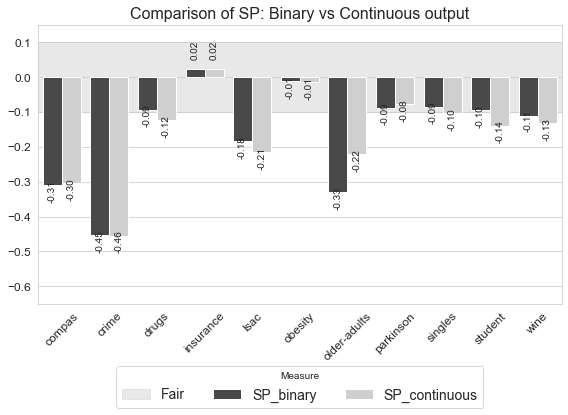

In [38]:
create_comparison_plots_adjusted(df_tree, metrics, ideal_values, fair_intervals)


In [127]:
# Modifying the provided code to transpose the plots completely

def create_transposed_comparison_plots(df, metrics, ideal_values, fair_intervals):
    for metric in metrics:
        # Prepare data for plotting
        df.sort_values(by=['dataset', 'attribute'], inplace=True)

        binary_data = df[df['method'] == 'binary'][['dataset', 'attribute', metric]]
        other_data = df[df['method'] != 'binary'][['dataset', 'attribute', metric, 'method']]

        # Merge binary and other data for comparison
        merged_data = pd.merge(binary_data, other_data, on=['dataset', 'attribute'], suffixes=('_binary', '_other'))

        # Melt the data for seaborn barplot
        melted_data = pd.melt(merged_data, id_vars=['dataset', 'attribute', 'method'],
                              value_vars=[f'{metric}_binary', f'{metric}_other'],
                              var_name='Method', value_name=metric)

        # Start plotting with transposed orientation (swap x and y axes)
        plt.figure(figsize=(6,9))

        # If a fair interval is specified, add a patch for it, and label it
        if metric in fair_intervals:
            plt.axvspan(fair_intervals[metric][0], fair_intervals[metric][1], color='#d3d3d3', alpha=0.5, label='Fair Range',
                        zorder=0)

        barplot = sns.barplot(data=melted_data, y='dataset', x=metric, hue='Method', palette=['#494949', '#cfcfcf'],
                              zorder=3)
        plt.yticks(rotation=45)
        plt.title(f'Comparison of {metric.capitalize()}: Binary vs Other Methods')

        # Add a vertical line for the ideal value
        if metric in ideal_values:
            plt.axvline(x=ideal_values[metric], color='black', linestyle='--', zorder=2)

        # Add the values on the bars
        for p in barplot.patches:
            # Check if the patch is a Rectangle object (which represents a bar)
            if isinstance(p, Rectangle):
                width = p.get_width()
                # Determine the horizontal alignment and set the offset
                ha = 'left' if width >= 0 else 'right'
                offset = 0.001 if width >= 0 else -0.01
                barplot.annotate(format(width, '.2f'),
                                 (width + offset, p.get_y() + p.get_height() / 2.),
                                 ha=ha, va='center',
                                 xytext=(9, 0),
                                 textcoords='offset points')

        # Place the legend
        plt.legend(title='Method', loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=len(df['method'].unique()))

        # Show the plot
        plt.tight_layout()
        plt.savefig(f'plots/transposed_regression_tree_{metric}_comparison.pdf',  bbox_inches='tight')




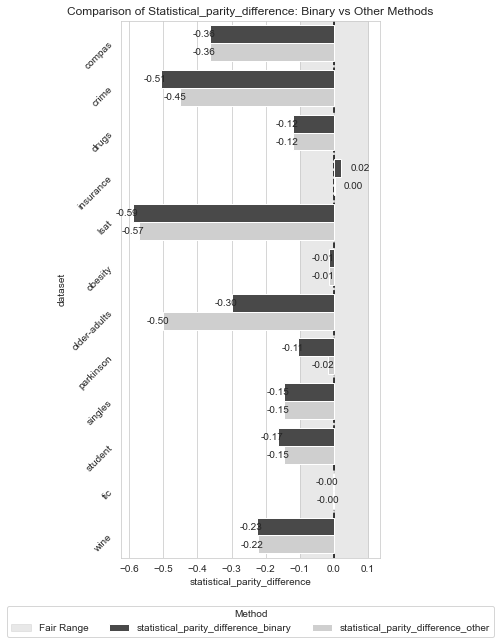

In [108]:
# Apply the modified function to the DataFrame
create_transposed_comparison_plots(df_reg, metrics, ideal_values, fair_intervals)

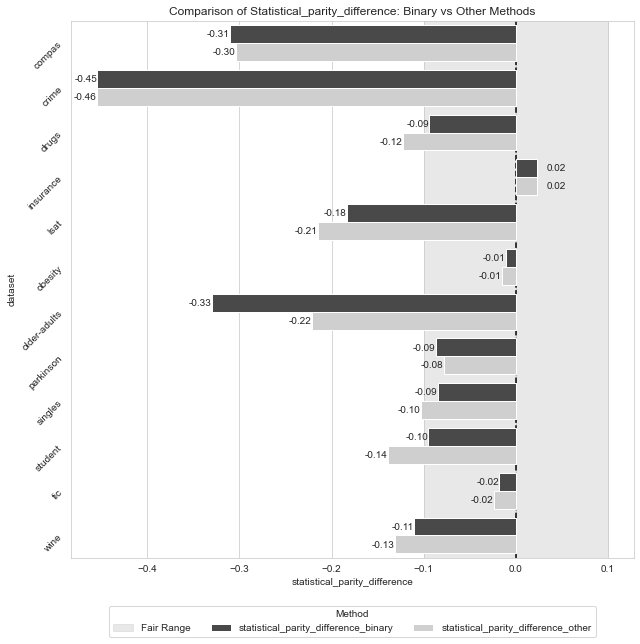

In [89]:
create_transposed_comparison_plots(df_tree, metrics, ideal_values, fair_intervals)


In [2]:
import pandas as pd
df = pd.read_csv('results/regression_tree/processed_quartiles_results_regression_metrics.csv')
df

,accuracies,statistical_parity_difference,mae_n,sp_avg_outcome_n,dataset,attribute,method
0,0.753,-0.110,0.049,-0.022,wine,color,binary
1,1.000,-0.221,0.383,0.186,older-adults,sex,continuous
2,0.791,-0.304,0.458,0.183,compas,race,ordinal
3,0.660,-0.095,0.018,-0.005,student,sex,binary
4,1.000,-0.131,1.036,-0.048,wine,color,ordinal
5,1.000,-0.078,0.588,0.044,parkinson,sex,continuous
6,0.720,-0.310,0.031,0.034,compas,race,binary
7,0.975,-0.018,0.004,-0.003,tic,religion,binary
8,0.560,-0.183,0.183,-0.076,lsat,race,binary
9,1.000,0.023,0.216,-0.019,insurance,sex,continuous


In [3]:
df = df[df.method != 'binary']
df

,accuracies,statistical_parity_difference,mae_n,sp_avg_outcome_n,dataset,attribute,method
1,1.000,-0.221,0.383,0.186,older-adults,sex,continuous
2,0.791,-0.304,0.458,0.183,compas,race,ordinal
4,1.000,-0.131,1.036,-0.048,wine,color,ordinal
5,1.000,-0.078,0.588,0.044,parkinson,sex,continuous
9,1.000,0.023,0.216,-0.019,insurance,sex,continuous
10,1.000,-0.455,0.346,0.307,crime,race,continuous
11,1.000,-0.024,0.826,0.004,tic,religion,ordinal
15,1.000,-0.015,0.501,-0.029,obesity,Gender,ordinal
17,0.981,-0.103,0.402,-0.087,singles,sex,ordinal
18,1.000,-0.139,0.603,-0.044,student,sex,continuous


In [4]:
# Sort the dataframe based on the 'sp_avg_outcome_n' column
sorted_df = df.sort_values('sp_avg_outcome_n')
sorted_df['sp_avg_outcome_n_abs'] = abs(sorted_df['sp_avg_outcome_n'])
sorted_df = sorted_df.sort_values('sp_avg_outcome_n_abs')
sorted_df.reset_index(drop=True, inplace=True)

In [5]:
sorted_df.drop(sorted_df[sorted_df['dataset'] == 'tic'].index, inplace = True)
sorted_df['dataset'] = sorted_df['dataset'].replace('lsat', 'lsac')


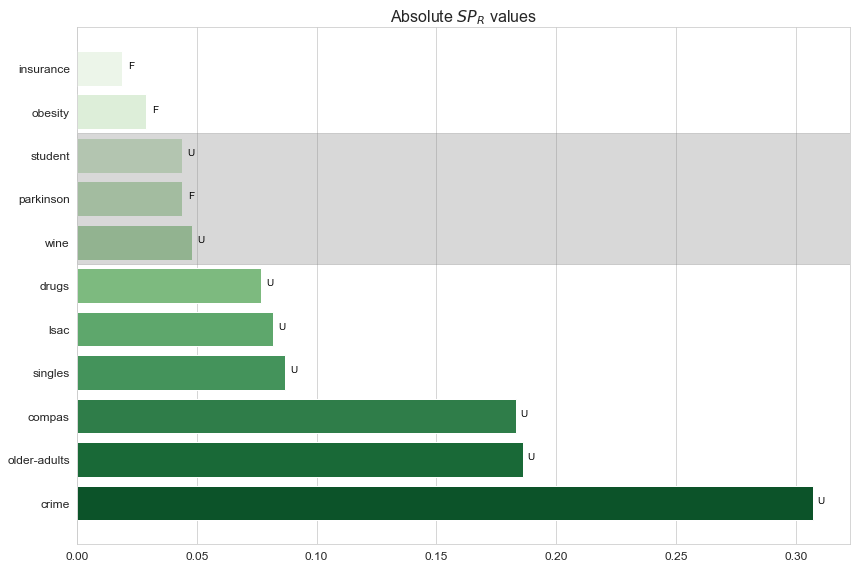

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
# Identifying the indices of the specific datasets 'student', 'parkinson', and 'wine'
band_datasets = ['student', 'parkinson', 'wine']
indices = sorted_df[sorted_df['dataset'].isin(band_datasets)].index

# Adding the band to the plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x=sorted_df['sp_avg_outcome_n_abs'], y=sorted_df['dataset'], palette="Greens")
plt.title('Absolute $SP_R$ values', fontsize=16)
# plt.xlabel('SP avg outcome')
# plt.ylabel('Data set')
plt.xlabel('')
plt.ylabel('')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding labels
for index, value in enumerate(sorted_df['statistical_parity_difference']):
    label = 'F' if (0.1 > value > -0.1) else 'U'
    adjusted_x_coordinate = sorted_df['sp_avg_outcome_n_abs'].iloc[index] + 0.005  # Adjust 0.05 to your needs
    plt.text(adjusted_x_coordinate, index, label, color='black', ha="right")

# Highlighting the band
plt.axhspan(min(indices)-1 - 0.5, max(indices) -1 + 0.5, color='gray', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/SP_continuous_band.pdf')
plt.show()

In [27]:
indices

Index([3, 4, 5], dtype='int64')